<a href="https://colab.research.google.com/github/joshbrx/biomath_model/blob/main/Voronoi_cells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# __Modelo de células con distribución espacial__

---

Import stantard libraries for plotting and necessary libraries from `SciPy`

In [315]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import random 
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.collections import LineCollection

from matplotlib.patches import Polygon

mpl.rcParams['figure.figsize'] = (8,6)

In [316]:
def vpoint_to_xy(vor, index):
    return vor.points[index]

def vpoint_to_region(vor, index):
    return vor.point_region[index]

def region_to_vpoint(vor, index):
    return np.where(vor.point_region == index)[0][0]

In [317]:
def vpoints_to_regions(vor, vpoints):
    regions = []
    for i in vpoints:
        regions.append(vpoint_to_region(vor, i))
    return regions

def regions_to_vpoints(vor, regions):
    vpoints = []
    for i in regions:
        vpoints.append(region_to_vpoint(vor, i))
    return vpoints

Ahora continuamos al definir las fronteras de nuestra superficie. Como queremos que se asemeje a una estructura acinar, simulamos un medio círculo interior y exterior.

\begin{align}
    \alpha(r, \theta) = r,\qquad\ \theta\in{\{0, \pi\}},\quad  r=\{1, 2\}
\end{align}

\begin{align}
    x &= r\cos\theta,\quad &y &= r\sin\theta\\
    \Rightarrow r &= \sqrt{x^2+y^2},\quad &\theta &= \arctan\left(\frac{y}{x}\right)
\end{align}

In [318]:
### parámetros
tol = 0.02; n_space = 100
theta = np.array([0, np.pi]);
r = np.array([1.0, 2.0]);
l = 1;

### funciones
alpha_x = lambda r, theta: r*np.cos(theta);
alpha_y = lambda r, theta: r*np.sin(theta);

In [319]:
def half_donut(r, theta, n_space, tol=0.2):
    X_border, Y_border = [], []

    X_border.append(np.concatenate((alpha_x(r[0] + tol*(-1), np.linspace(theta[0], theta[1], n_space//3)), alpha_x(r[1] + tol, np.linspace(theta[0], theta[1], n_space))), axis=0))
    Y_border.append(np.concatenate((alpha_y(r[0] + tol*(-1), np.linspace(theta[0], theta[1], n_space//3)), alpha_y(r[1] + tol, np.linspace(theta[0], theta[1], n_space))), axis=0))

    X_border = np.array(X_border).flatten()
    Y_border = np.array(Y_border).flatten()
    pts_border = np.array([X_border, Y_border])
    return pts_border

#----------------------------------------
def tunnels(r, l, n_space, tol=0.2):
    X_tunnel, Y_tunnel = [], []
    for i in range(2):
        X_tunnel.append(np.concatenate((np.ones(n_space//4)*r[i] + tol*(-1)**(i+1), -np.ones(n_space//4)*r[i] - tol*(-1)**(i+1), np.linspace(r[0]-tol, r[1]+tol, num=n_space//6)*(-1)**(i)), axis=0))
        Y_tunnel.append(np.concatenate((np.linspace(0,-l, num=n_space//4), np.linspace(0,-l, num=n_space//4), -np.ones(n_space//6)*l), axis=0))

    X_tunnel = np.array(X_tunnel).flatten()
    Y_tunnel = np.array(Y_tunnel).flatten()
    pts_tunnel = np.array([X_tunnel, Y_tunnel])
    return pts_tunnel

#----------------------------------------
def get_structure(r, theta, l, n_space, tol=0.2):
    # pts_structure = []
    donut = half_donut(r, theta, n_space, tol=tol)
    tunnel = tunnels(r, l, n_space, tol=tol)
    pts_structure = np.concatenate((donut, tunnel), axis=1)
    return pts_structure

#----------------------------------------
def rand_points(r, theta, N, tol=0.02):
    r_rand     = np.random.rand(N) * abs(r[-1]-r[0]-2*tol) + r[0] + tol
    theta_rand = np.random.rand(N) * abs(theta[1]-theta[0]) + theta[0]

    X_rand = alpha_x(r_rand, theta_rand)
    Y_rand = alpha_y(r_rand, theta_rand)
    pts_rand = np.array([X_rand, Y_rand])
    return pts_rand

# plt.scatter(half_donut(r, theta, n_space)[0], half_donut(r, theta, n_space)[1])
# plt.scatter(tunnels(r, l, n_space)[0], tunnels(r, l, n_space)[1])

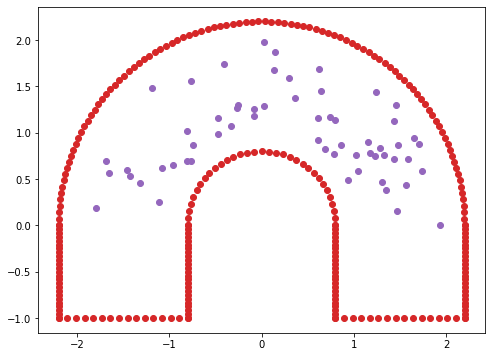

In [320]:
N = 60;
tol = 0.2;

pts_structure = get_structure(r, theta, l, n_space, tol=0.2)
pts_rand = rand_points(r, theta, N, tol=0.02).T

plt.scatter(pts_rand.T[0], pts_rand.T[1], color="tab:purple")
plt.scatter(pts_structure[0], pts_structure[1], color="tab:red")

In [321]:
def mk_voronoi(points, pts_structure):
    total = np.concatenate((points, pts_structure.T))
    vor = Voronoi(total)
    return vor

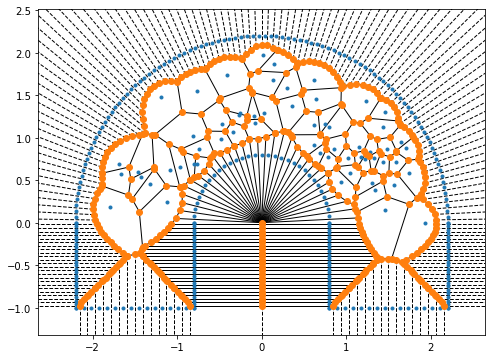

<Figure size 1080x504 with 0 Axes>

In [322]:
vor = mk_voronoi(pts_rand, pts_structure)

voronoi_plot_2d(vor)
# plt.ylim([-1.1,2.1])
plt.figure(figsize=(15,7))
plt.show()

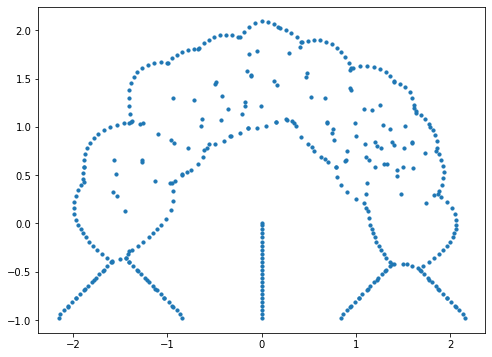

In [323]:
plt.scatter(vor.vertices[:,0], vor.vertices[:,1], s=10)

*   ###  __Paso $N+1$:__ _Encontrando y discriminando las regiones de Voronoi_



In [324]:
# vor.ridge_dict

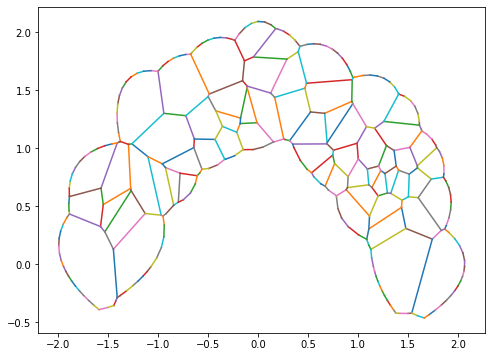

In [325]:
finite_segments = []
temp_dict = vor.ridge_dict
temp_keys = temp_dict.keys()

for key in temp_keys:
    if np.all(np.asarray(temp_dict[key]) >= 0) and np.any(np.asarray(key) < len(pts_rand)):
        finite_segments.append(vor.vertices[np.asarray(temp_dict[key])])

for i in range(len(finite_segments)):
    x_line = finite_segments[i][:,0]
    y_line = finite_segments[i][:,1]
    plt.plot(x_line, y_line)

In [326]:
def get_polygons(vor, N_points):
    Polygons, regions = [], []
    nregions = len(vor.regions)
    for i in range(len(vor.regions)):
        if (not -1 in vor.regions[i]) and (len(vor.regions[i]) >=1):
            polygon = np.array([vor.vertices[k] for k in vor.regions[i]])
            Polygons.append(np.array([*zip(*polygon)]))
            regions.append(i)

    vpoints = regions_to_vpoints(vor, regions)
    Polygons = [x for _,x in sorted(zip(vpoints, Polygons))][:N_points]

    return Polygons

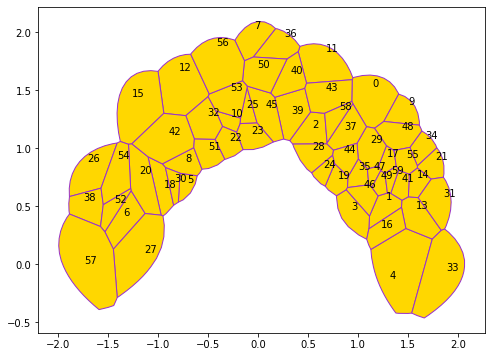

In [327]:
### make up data points
points = np.random.rand(15,2)

### compute Voronoi tesselation
vor = mk_voronoi(pts_rand, pts_structure)

### get Voronoi regions
N_points = len(pts_rand)
Polygons = get_polygons(vor, N_points)

### visualize Voronoi regions
for i in range(len(Polygons)):
    polygon = Polygons[i]
    X, Y = polygon
    plt.text(np.mean(X), np.mean(Y) + 0.05, f"{i}")
    plt.fill(X, Y, edgecolor="darkorchid", facecolor="gold")
plt.show()

In [328]:
len(Polygons)           # Número de polígonos guardados (coincide con el número de puntos dados)
# x[i] -> Polygons[i][0]
# y[i] -> Polygons[i][1]

60


*   ###  __Paso $N+2$:__ _Calculando el área y el centroide de un polígono_

\begin{align}
    A &= \frac{1}{2}\sum_{i=0}^{N-1} (x_iy_{i+1}-x_{i+1}y_i)
\end{align}

Y para el cálculo de las coordenadas del centro de masas en 2D tenemos las siguientes ecuaciones

\begin{align}
    C_x &= \frac{1}{6A}\sum_{i=0}^{N-1}(x_i+x_{i+1})(x_iy_{i+1}-x_{i+1}y_i) \\
    C_y &= \frac{1}{6A}\sum_{i=0}^{N-1}(y_i+y_{i+1})(x_iy_{i+1}-x_{i+1}y_i)
\end{align}

Para mayor información puede consultar el siguiente enlace: [Calculating the area and centroid of a polygon. By Paul Bourke](https://lexrent.eu/wp-content/uploads/torza/artikel_groep_sub_2_docs/BYZ_3_Polygon-Area-and-Centroid.pdf)

-----

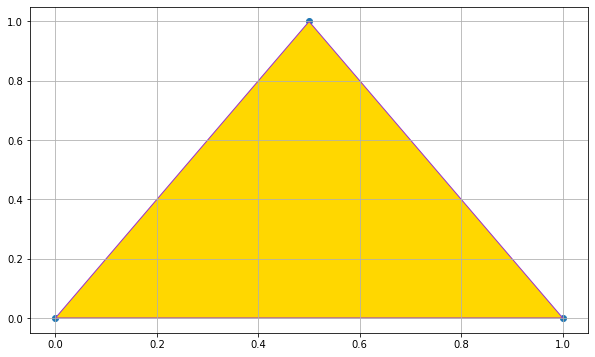

In [329]:
x_prueba = np.array([0,1,0.5])
y_prueba = np.array([0,0,1])

polygon_prueba = np.array([x_prueba, y_prueba])

plt.figure(figsize=(10,6))
plt.scatter(x_prueba, y_prueba); plt.fill(x_prueba, y_prueba, edgecolor="darkorchid", facecolor="gold")
plt.grid()

In [330]:
def get_area(Polygons, index=None):
    if index == None:
        n_area = Polygons.shape[1]
        X, Y = Polygons
    else:
        n_area = Polygons[index].shape[1]
        X, Y = Polygons[index]
    S = np.empty(n_area)
    
    for i in range(n_area):
        S[i] = X [i]*Y[(i+1) % n_area] - X[(i+1) % n_area]*Y[i]
    return abs((1/2)*np.sum(S))

# get_area(polygon_prueba)

In [331]:
def area_voronoi(Polygons):
    nregions = len(Polygons)
    S = np.empty(nregions)

    for i in range(nregions):
        S[i] = get_area(Polygons, index=i)
    return S

# area_voronoi(Polygons)

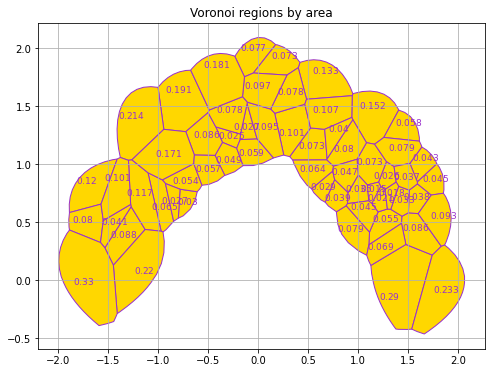

In [332]:
A_vor = area_voronoi(Polygons)

for i in range(len(Polygons)):
    X, Y = Polygons[i]
    num_label = round(A_vor[i], 3)
    plt.text(np.mean(X), np.mean(Y), f'${num_label}$', fontsize=9, horizontalalignment='center', color='darkorchid', fontweight='bold')
    plt.fill(X, Y, edgecolor="darkorchid", facecolor="gold")

plt.title("Voronoi regions by area")
plt.grid()

---

Ahora se calcula el centroide de cada polígono

In [333]:
def get_centroid(Polygons, index=None, tol = 0.02):
    if index == None:
        n_centroid = Polygons.shape[1]
        X, Y = Polygons
        A = get_area(Polygons)
    else:
        n_centroid = Polygons[index].shape[1]
        X, Y = Polygons[index]
        A = get_area(Polygons[index])
    CX, CY = np.empty([2, n_centroid])
    
    for i in range(n_centroid):
        CX[i] = (X[i] + X[(i+1) % n_centroid]) * (X[i] * Y[(i+1) % n_centroid] - X[(i+1) % n_centroid]*Y[i])
        CY[i] = (Y[i] + Y[(i+1) % n_centroid]) * (X[i] * Y[(i+1) % n_centroid] - X[(i+1) % n_centroid]*Y[i])
     
    cX, cY = (np.sum(CX), np.sum(CY))/(6*A) 
    if abs(cX - np.mean(X)) > abs(-cX - np.mean(X)):
        cX = -cX
    if abs(cY - np.mean(Y)) > abs(-cY - np.mean(Y)):
        cY = -cY
    return cX, cY

# get_centroid(polygon_prueba);

In [334]:
def centroid_voronoi(Polygons):
    nregions = len(Polygons)
    C = np.empty([2, nregions])
    for i in range(nregions):
        C[:,i] = get_centroid(Polygons, index=i)
    return C

centroid_voronoi(Polygons);

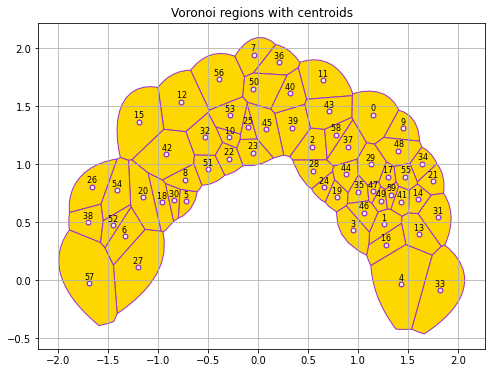

In [335]:
C_vor = centroid_voronoi(Polygons);
fig, ax = plt.subplots();

for i in range(len(Polygons)):
    X, Y = Polygons[i]
    num_label = round(get_area(Polygons[i]), 3)
    plt.text(C_vor[0,i], C_vor[1,i]+0.035, f'${i}$', fontsize=8, horizontalalignment='center', color='black', fontweight='bold')
    ax.fill(X, Y, zorder=-2, edgecolor="darkorchid", facecolor="gold")
ax.scatter(C_vor[0], C_vor[1], color="darkorchid", zorder=1, s=25)
ax.scatter(C_vor[0], C_vor[1], color="azure", zorder=2, s=5)

plt.title("Voronoi regions with centroids"); plt.grid()

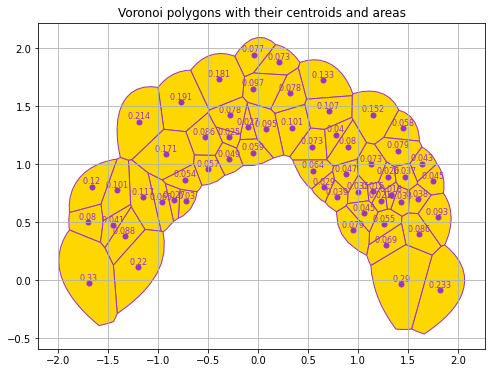

In [336]:
A_vor = area_voronoi(Polygons);
C_vor = centroid_voronoi(Polygons);

for i in range(len(Polygons)):
    X, Y = Polygons[i]
    num_label = round(A_vor[i], 3)
    plt.text(C_vor[0,i], C_vor[1,i]+0.025, f'${num_label}$', fontsize=8, horizontalalignment='center', color='darkorchid', fontweight='bold', zorder=1)
    plt.fill(X, Y, zorder=-2, edgecolor="darkorchid", facecolor="gold")

plt.scatter(C_vor[0], C_vor[1], color="darkorchid", zorder=-1, s=25); ax.scatter(C_vor[0], C_vor[1], color="azure", zorder=0, s=5)
plt.title("Voronoi polygons with their centroids and areas")
plt.grid()

*   ###  __Paso $N+3$:__ _Definiendo las interacciones y evolución del sistema a partir del potencial $V(\vec{x},t)$_

\begin{align}
    V(\vec{r_i}, t) = \frac{K_v}{2}\left(A_i(t)-A_0(t)\right)^2 + \frac{K_c}{2}\big|\vec{r}_i(t) - \vec{r}_{0,i}(t)\big|^2 
\end{align}

donde $A_0 = \sum_{i=1}^N(A_i/N)$

[Cell Patterns Emerge from Coupled Chemical and Physical Fields with Cell Proliferation Dynamics: The Arabidopsis thaliana Root as a Study System](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3642054/)

\begin{align}
    A_{1/2,dona} &= \frac{\pi}{2} \left(r_{max}^2-r_{min}^2\right)\\
    \Rightarrow A_0 &= \lim_{t\to\infty} A_i(t)=\frac{A_{1/2,dona}}{N_{reg}} = \frac{\pi}{2N} \left(r_{max}^2-r_{min}^2\right)
\end{align}

In [337]:
A_dona = (np.pi/2*0.7)*(r[1]**2 - r[0]**2)
A_0 = A_dona/len(Polygons)
A_0

0.05497787143782138

In [338]:
K_v, K_c = 1, 1

# (K_v/2)*(A_vor-A_0)**2                # evolución estática
(K_v/2)*(A_vor-np.mean(A_vor))**2;    # evolución dinámica

In [339]:
def dist_vor(pts_vor, C_vor):
    dist, index = [], []
    for i in range(len(pts_vor)):
        s = pts_rand[i].reshape([2,1])
        dist.append(np.min(np.sum((C_vor - s)**2, axis=0)))
        index.append(np.argmin(np.sum((C_vor - s)**2, axis=0)))

    return np.array(dist), np.array(index)

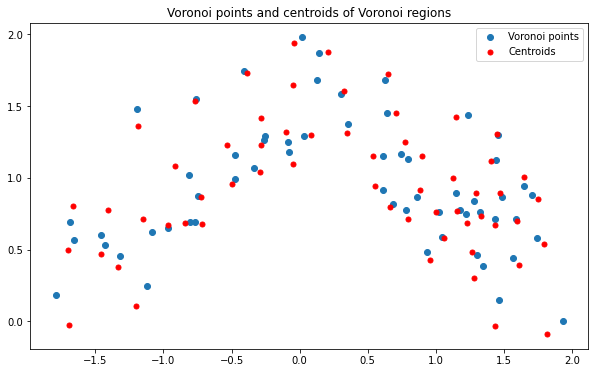

In [340]:
plt.figure(figsize=(10,6))
plt.scatter(pts_rand.T[0],pts_rand.T[1], label="Voronoi points")
plt.scatter(C_vor[0], C_vor[1], color="red", s=25, label="Centroids")
plt.title("Voronoi points and centroids of Voronoi regions"); plt.legend()

In [341]:
K = [0.5, 0.5, 0.5]
A_0 = (np.pi/2)*(r[1]**2 - r[0]**2)/len(Polygons)

def potential_vor(K, pts_vor, A_vor, C_vor):
    V = np.empty(len(pts_vor))
    dist, index = dist_vor(pts_vor, C_vor)

    # v1 = ((K[0]/2)*(A_vor-A_0)**2)[index]               # evolución estática
    v1 = ((K[0]/2)*(A_vor-np.mean(A_vor))**2)[index]
    v2 = (K[1]/2)*dist
    return v1 + v2

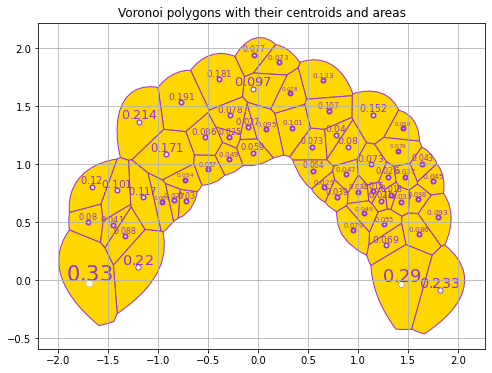

In [342]:
V_vor = potential_vor(K, pts_rand, A_vor, C_vor)

for i in range(len(Polygons)):
    X, Y = Polygons[i]
    num_label = round(A_vor[i], 3)
    plt.text(C_vor[0,i], C_vor[1,i]+0.025, f'${num_label}$', fontsize=np.sqrt(V_vor[i])*100+4, horizontalalignment='center', color='darkorchid', fontweight='bold', zorder=1)
    plt.fill(X, Y, zorder=-2, edgecolor="darkorchid", facecolor="gold")
    plt.scatter(C_vor[0,i], C_vor[1,i], color="azure", zorder=0, s=V_vor[i]*1000)

plt.scatter(C_vor[0], C_vor[1], color="darkorchid", zorder=-1, s=25); 
plt.title("Voronoi polygons with their centroids and areas")
plt.grid()

\begin{align}
    F_x(x_i, t) = &-\frac{K_v}{2}\left[\frac{1}{2}\sum_{m=1}^{M} \frac{(x_i-x_m)\cdot l_{i,m}}{|\vec{r}_i-\vec{r}_m|}\{A_i - A_0\}\right]\\
                  &- K_c(x_i-x_{0,i})\\
    F_y(y_i, t) = &-\frac{K_v}{2}\left[\frac{1}{2}\sum_{m=1}^{M} \frac{(y_i-y_m)\cdot l_{i,m}}{|\vec{r}_i-\vec{r}_m|}\{A_i - A_0\}\right]\\
                  &- K_c(y_i-y_{0,i})  
\end{align}

In [343]:
def get_lines(vor):
    line_segments, line_regions = [], []
    for simplex, pointidx in zip(vor.ridge_vertices, vor.ridge_points):
        if -1 not in simplex:
            pointidx = np.asarray(pointidx)
            simplex = np.asarray(simplex)
            if np.all(pointidx <= len(pts_rand)-1):
                line_segments.append(vor.vertices[simplex])
                line_regions.append(pointidx)
    line_segments = np.array(line_segments)
    line_regions = np.array(line_regions)
    return line_segments, line_regions

get_lines(vor)[0], get_lines(vor)[1];

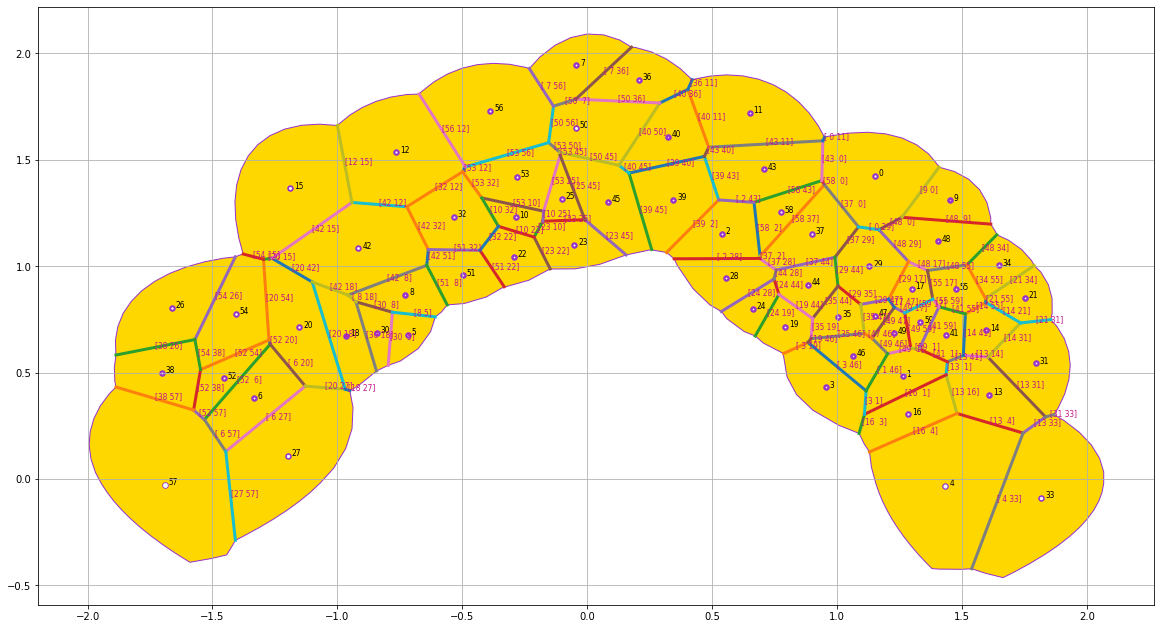

In [344]:
Line_segments, Line_regions = get_lines(vor)
plt.figure(figsize=(20,11))

### Plot shared lines 
for i in range(len(Line_segments)):
    line_segment = Line_segments[i]
    x_line = line_segment[:,0]
    y_line = line_segment[:,1]
    plt.plot(x_line, y_line, linewidth=3)
    plt.text(np.mean(x_line), np.mean(y_line), f"{Line_regions[i]}", color="mediumvioletred", zorder=2, fontsize=7.5)

### Visualize Voronoi regions
for i in range(len(Polygons)):
    X, Y = Polygons[i]
    plt.fill(X, Y, zorder=-2, edgecolor="darkorchid", facecolor="gold")
    plt.text(C_vor[0,i]+0.015, C_vor[1,i], f"{i}", color="black", zorder=0, fontsize=7.5)
    plt.scatter(C_vor[0,i], C_vor[1,i], color="azure", zorder=0, s=V_vor[i]*500)
plt.scatter(C_vor[0], C_vor[1], color="darkorchid", zorder=-1, s=30); 
plt.grid()

In [345]:
def get_dist_dict(vor):
    dist_dict = {}
    Line_segments, Line_regions = get_lines(vor)
    for k in range(len(Line_regions)):
        i, m = sorted(Line_regions[k])
        d = np.sum((Line_segments[k][0]-Line_segments[k][1])**2)
        dist_dict[(i,m)] = d
    return dist_dict

dist_dict = get_dist_dict(vor)

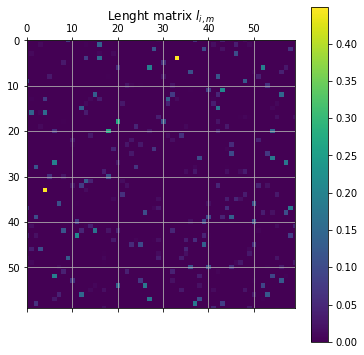

In [346]:
s = (len(pts_rand), len(pts_rand))
empty_matrix = np.zeros(s)
for k in range(len(Line_regions)):
    i, m = sorted(Line_regions[k])
    d = np.sum((Line_segments[k][0]-Line_segments[k][1])**2)
    empty_matrix[i,m] += d
    empty_matrix[m,i] += d

plt.matshow(empty_matrix);
plt.xlim([0,len(Polygons)-1]); plt.ylim([len(Polygons)-1,0]);
plt.title("Lenght matrix $l_{i,m}$"); plt.colorbar(); plt.grid()

In [347]:
def F(K, A_mean, dist_dict, Polygons, i, t):
    f, v, l = np.zeros(2),np.zeros(2), np.zeros(2)

    for key in dist_dict.keys():
        a, b = key
        if (a == i) or (b == i):
            if a == i: pass
            else: b, a = a, b
            r = vor.points[a] - vor.points[b]
            # l += (dist_dict[key] * r * (get_area(Polygons, index=i) - A_0)) / (np.linalg.norm(r))          # evolución estática
            l += (dist_dict[key] * r * (get_area(Polygons, index=i) - A_mean)) / (np.linalg.norm(r))      # evolución dinámica
        else: pass
    f = -(K[0] * l)/4 - K[1]*(vor.points[i] - get_centroid(Polygons, index=i, tol = 0.02))
    return f

## Evolución del sistema

\begin{align}
    \frac{d\vec{r}}{dt} &= \vec{v} \\
    \frac{d\vec{v}}{dt} &= \vec{F}_T
\end{align}

In [373]:
def dX(dist_dict, Polygons, X0, t, K, A_mean=None):
    X_pts, V_pts = X0[:,0:2], X0[:,2:4]
    if A_mean == None:
        A_mean = np.median(area_voronoi(Polygons))
    else: pass
    dX = V_pts                    # (dx, dy) = (Vx, Vy)
    dV = np.empty(V_pts.shape)    # (dVx, dVy) = (Fx, Fy)

    for i in range(V_pts.shape[0]):
        dV[i] = F(K, A_mean, dist_dict, Polygons, i, t) - K[2]*dX[i]
    return np.concatenate([dX, dV], axis=1)

In [374]:
def RK_solver(X0, dX, t, K, points, A_fixed=None):
    points = X0[:,0:2]
    vor = mk_voronoi(points, pts_structure)

    N_points = len(points)
    Polygons = get_polygons(vor, N_points)
    dist_dict = get_dist_dict(vor)
    if A_fixed == None:
        A_fixed = np.mean(area_voronoi(Polygons))
    
    RK = np.empty([4, X0.shape[0], X0.shape[1]])
    X = np.empty([2, X0.shape[0], X0.shape[1]])
    X[0] = X0
    dt = t[1] - t[0]; 

    for i in range(len(t)):
        RK[0] = dt * dX(dist_dict, Polygons, X0, t[i], K, A_mean=A_fixed)
        RK[1] = dt * dX(dist_dict, Polygons, X0 + RK[0]/2, t[i] + dt/2, K, A_mean=A_fixed)
        RK[2] = dt * dX(dist_dict, Polygons, X0 + RK[1]/2, t[i] + dt/2, K, A_mean=A_fixed)
        RK[3] = dt * dX(dist_dict, Polygons, X0 + RK[2]  , t[i] + dt, K, A_mean=A_fixed)

        ss = RK[0] + 2*RK[1] + 2*RK[2] + RK[3]
        X0 += ss/6
        vor = mk_voronoi(X0[:,0:2], pts_structure)
        Polygons = get_polygons(vor, N_points)
        dist_dict = get_dist_dict(vor)
        A_fixed = np.mean(area_voronoi(Polygons))
    X[1] = X0
    return X

def euler_solver(X0, dX, t, K, points, A_fixed=None):
    points = X0[:,0:2]
    vor = mk_voronoi(points, pts_structure)

    N_points = len(points)
    Polygons = get_polygons(vor, N_points)
    dist_dict = get_dist_dict(vor)
    if A_fixed == None:
        A_fixed = np.mean(area_voronoi(Polygons))

    dims = len(X0)
    X = np.empty([2, X0.shape[0], X0.shape[1]])
    X[0] = X0
    dt = t[1] - t[0]; 

    for i in range(len(t)):
        X0 += dt * dX(dist_dict, Polygons, X0, t[i], K, A_mean=A_fixed)

        vor = mk_voronoi(X0[:,0:2], pts_structure)
        Polygons = get_polygons(vor, N_points)
        dist_dict = get_dist_dict(vor)
        A_fixed = np.mean(area_voronoi(Polygons))
    X[1] = X0
    return X

In [375]:
def evolve_vornonoi(X0, dX, K, points, pts_structure, step=0.001, lenght=100, iter=20, vel=(0,0.01), method="RK4", A_fixed=None):
    """
    solver["RK4"]: Runge-Kutta order 4
    solver["Euler"]: Euler method
    """
    X0 = np.concatenate([points, np.random.normal(vel[0], vel[1], points.shape)], axis=1)       # mov. browniano inicial
    X_out, V_out = X0[:,0:2], X0[:,2:4]
    solvers_dict = {"RK4":RK_solver, "Euler":euler_solver}
    solver = solvers_dict[method]
    t = np.arange(0, lenght*step, step)

    vor_out = mk_voronoi(X_out, pts_structure)
    voronoi_plot_2d(vor_out); plt.grid()
    plt.title(f"Gráfica: {0},    t={0},    method: {method}"); plt.show()

    for i in range(iter):
        X0 = solver(X0, dX, t, K, pts_rand, A_fixed=A_fixed)[1]
        X_out, V_out = X0[:,0:2], X0[:,2:4]

        vor_out = mk_voronoi(X_out, pts_structure)
        voronoi_plot_2d(vor_out); plt.grid()
        plt.title(f"Gráfica: {i+1},    t={round(step*lenght*(i+1), 2)},    method: {method}"); plt.show()

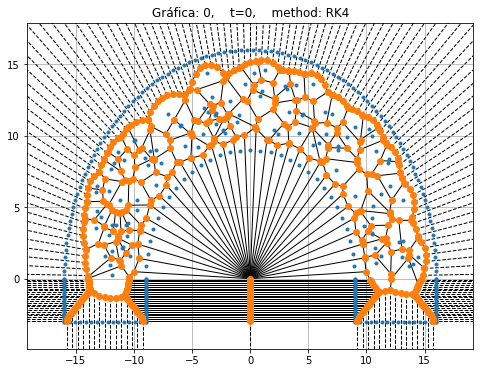

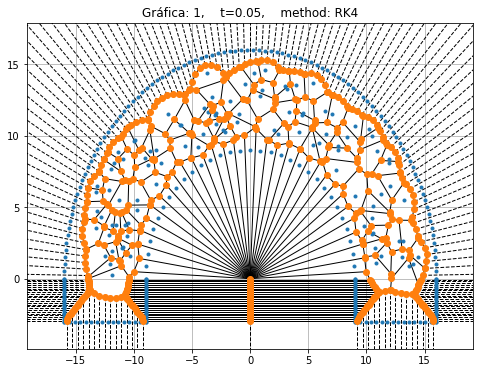

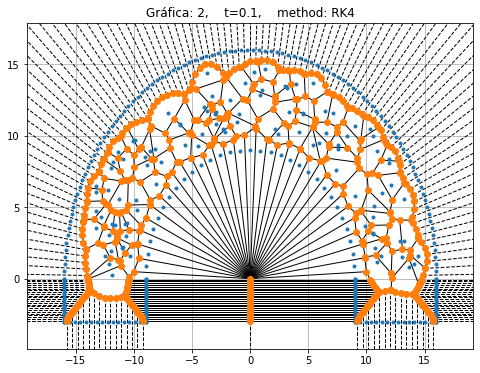

In [ ]:
N = 100; l = 3;

r = np.array([10, 15]); theta = np.array([0, np.pi])
pts_rand = rand_points(r, theta, N, tol=0.15).T; pts_structure = get_structure(r, theta, l, 100, tol=1)
step = 0.0005; lenght = 100;
K = [0.5, 0.9, 0.4]
A_0 = (A_dona/N) * 0.5

# r_rand = np.ones(N) * 1.2;
# theta_rand = np.linspace(tol, np.pi-tol, N);
# X_rand = alpha_x(r_rand, theta_rand); Y_rand = alpha_y(r_rand, theta_rand)
# pts_rand = np.array([X_rand, Y_rand]).T

evolve_vornonoi(X0, dX, K, pts_rand, pts_structure, step=step, lenght=lenght, iter=100, vel=(0,0.001), method="RK4", A_fixed=None)